# Logistic Regression

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from pprint import pprint
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from database_info import NAME, USER, PASSWORD, HOST, PORT

In [2]:
# Connect to the sql database
DATABASES = {
    'production':{
        'NAME': NAME,
        'USER': USER,
        'PASSWORD': PASSWORD,
        'HOST': HOST,
        'PORT': PORT,
    },
}

# choose the database to use
db = DATABASES['production']

# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)
conn = engine.connect()


In [3]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['passenger_information', 'survival']

# Model 1

In [4]:
# Extracting relevant fields from sql
titanic_one = pd.read_sql_query("""
SELECT s.survived,
p.sex,
p.sibsp,
p.parch,
p.age_updated,
p.embarked_updated,
p.fare_updated,
p.deck,
p.pclass_updated
FROM passenger_information as p
LEFT JOIN survival as s ON p.passenger_id=s.passenger_id""", conn)
titanic_one.head()

,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class


### Prepare the data

<h7> Convert categorical data

In [27]:
# Converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic_one['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic_one['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic_one['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic_one['pclass_updated'], drop_first=True)

In [28]:
# Concatenate the encoded dummies with the dataframe
df_titanic_transformed = pd.concat([titanic_one,sex_dummies, embarked_dummies, deck_dummies,  pclass_dummies], axis=1)
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated'], axis=1) # dropping columns not required
df_titanic_transformed.head()

,survived,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,E,F,G,T,Unknown,Second class,Third class
0,1,0,0,29.0000,211.3375,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,1,2,0.9167,151.5500,1,0,1,0,1,0,0,0,0,0,0,0,0
2,0,1,2,2.0000,151.5500,0,0,1,0,1,0,0,0,0,0,0,0,0
3,0,1,2,30.0000,151.5500,1,0,1,0,1,0,0,0,0,0,0,0,0
4,0,1,2,25.0000,151.5500,0,0,1,0,1,0,0,0,0,0,0,0,0


### Separate the data into labels and features

In [29]:
# Separate the features (X) from the target (y)
y = df_titanic_transformed["survived"]
X = df_titanic_transformed.drop(columns='survived')

In [30]:
# Reivew the y variable series
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [31]:
# Review the X variable dataframe
X.head()

,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,E,F,G,T,Unknown,Second class,Third class
0,0,0,29.0000,211.3375,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,2,0.9167,151.5500,1,0,1,0,1,0,0,0,0,0,0,0,0
2,1,2,2.0000,151.5500,0,0,1,0,1,0,0,0,0,0,0,0,0
3,1,2,30.0000,151.5500,1,0,1,0,1,0,0,0,0,0,0,0,0
4,1,2,25.0000,151.5500,0,0,1,0,1,0,0,0,0,0,0,0,0


In [32]:
# Check the balance of our target values
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

### Split data into training and testing datasets using train_test_split

In [33]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(981, 17)

In [34]:
y_test.value_counts()

0    203
1    125
Name: survived, dtype: int64

### Logisitic regression model

In [35]:
# Create a logistic regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=600, random_state=1)

# Fit and train the model using the training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=600, random_state=1)

In [36]:
# Make predictions
predictions = classifier.predict(X_test)
lr1_predictions_actuals_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test})

### Evaluate the models performance

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, predictions, target_names=target_names))

The balanced accuracy score of the model is 0.7707389162561576




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,183,20
Actual - Survived,45,80




                 precision    recall  f1-score   support

Did not survive       0.80      0.90      0.85       203
       Survived       0.80      0.64      0.71       125

       accuracy                           0.80       328
      macro avg       0.80      0.77      0.78       328
   weighted avg       0.80      0.80      0.80       328



# Model 1 - optimisation
<h7> Applying random over sampling due to the imbalanced data and re-running model

In [38]:
# Instantiate the random oversampler model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    606
0    606
Name: survived, dtype: int64

### Create logistic regression model with the original data

In [39]:
# Create a logistic regression model
ros_model = LogisticRegression(solver='lbfgs', max_iter=600, random_state=1)

# Fit and train the model using the training data
ros_model.fit(X_train_ros, y_train_ros)

# Make predictions
ros_predictions = ros_model.predict(X_test)

### Evaluate the models performance

In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, ros_predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, ros_predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, ros_predictions, target_names=target_names))

The balanced accuracy score of the model is 0.7796453201970444




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,172,31
Actual - Survived,36,89




                 precision    recall  f1-score   support

Did not survive       0.83      0.85      0.84       203
       Survived       0.74      0.71      0.73       125

       accuracy                           0.80       328
      macro avg       0.78      0.78      0.78       328
   weighted avg       0.79      0.80      0.79       328



# Model two 
<h7> Optimisation made - added together the number of family members passenger were travelling with and added it as a new field

### Preparing the data

In [5]:
# Extracting relevant fields from sql
titanic_two = pd.read_sql_query("""
SELECT s.survived,
    p.sex,
    p.sibsp,
    p.parch,
    p.age_updated,
    p.embarked_updated,
    p.fare_updated,
    p.deck,
    p.pclass_updated
FROM passenger_information as p
LEFT JOIN survival as s 
    ON p.passenger_id=s.passenger_id""", conn)
titanic_two.head()

,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class


<h7> Adding field that calculates the number of family members they were travelling with

In [42]:
# summing the number of family members
titanic_two['family_members'] = titanic_two['sibsp'] + titanic_two['parch']

# Dropping sibsp and parch columns as they are included in the new column
titanic_two = titanic_two.drop(['sibsp', 'parch'], axis=1) 

titanic_two.head()

,survived,sex,age_updated,embarked_updated,fare_updated,deck,pclass_updated,family_members
0,1,female,29.0000,Southampton (UK),211.3375,B,First class,0
1,1,male,0.9167,Southampton (UK),151.5500,C,First class,3
2,0,female,2.0000,Southampton (UK),151.5500,C,First class,3
3,0,male,30.0000,Southampton (UK),151.5500,C,First class,3
4,0,female,25.0000,Southampton (UK),151.5500,C,First class,3


<h7> Convert categorical data

In [43]:
# Converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic_two['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic_two['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic_two['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic_two['pclass_updated'], drop_first=True)

In [44]:
# Concatenate the encoded dummies with the dataframe
df_titanic_transformed = pd.concat([titanic_two, sex_dummies, embarked_dummies, deck_dummies, pclass_dummies], axis=1)
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated'], axis=1) # dropping columns not required
df_titanic_transformed.head()

,survived,age_updated,fare_updated,family_members,male,Queenstown (IE),Southampton (UK),B,C,D,E,F,G,T,Unknown,Second class,Third class
0,1,29.0000,211.3375,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,0.9167,151.5500,3,1,0,1,0,1,0,0,0,0,0,0,0,0
2,0,2.0000,151.5500,3,0,0,1,0,1,0,0,0,0,0,0,0,0
3,0,30.0000,151.5500,3,1,0,1,0,1,0,0,0,0,0,0,0,0
4,0,25.0000,151.5500,3,0,0,1,0,1,0,0,0,0,0,0,0,0


### Separate the data into labels and features

In [45]:
# Separate the features (X) from the target (y)
y = df_titanic_transformed["survived"]
X = df_titanic_transformed.drop(columns='survived')

In [46]:
# Reivew the y variable series
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [47]:
# Review the X variable dataframe
X.head()

,age_updated,fare_updated,family_members,male,Queenstown (IE),Southampton (UK),B,C,D,E,F,G,T,Unknown,Second class,Third class
0,29.0000,211.3375,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,0.9167,151.5500,3,1,0,1,0,1,0,0,0,0,0,0,0,0
2,2.0000,151.5500,3,0,0,1,0,1,0,0,0,0,0,0,0,0
3,30.0000,151.5500,3,1,0,1,0,1,0,0,0,0,0,0,0,0
4,25.0000,151.5500,3,0,0,1,0,1,0,0,0,0,0,0,0,0


In [48]:
# Check the balance of our target values
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

### Split data into training and testing datasets using train_test_split

In [49]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(981, 16)

### Apply random over sampler due to the imblanced data

In [50]:
# Instantiate the random oversample model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    606
0    606
Name: survived, dtype: int64

### Create logistic regression model with the original data

In [51]:
# Create a logistic regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=800, random_state=1)

# Fit and train the model using the training data
classifier.fit(X_train_ros, y_train_ros)

LogisticRegression(max_iter=800, random_state=1)

In [52]:
# Make predictions
predictions = classifier.predict(X_test)

### Evaluate the models performance

In [53]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, predictions, target_names=target_names))

The balanced accuracy score of the model is 0.77471921182266




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,170,33
Actual - Survived,36,89




                 precision    recall  f1-score   support

Did not survive       0.83      0.84      0.83       203
       Survived       0.73      0.71      0.72       125

       accuracy                           0.79       328
      macro avg       0.78      0.77      0.78       328
   weighted avg       0.79      0.79      0.79       328



# Model 3 
<h7> Optimisation made - extracting title from the name and using that as a field and including the columns sibsp and parch (due to earlier results)

In [6]:
# Extracting relevant fields from sql
titanic_three = pd.read_sql_query("""
SELECT s.survived,
    p.name,
    p.sex,
    p.sibsp,
    p.parch,
    p.age_updated,
    p.embarked_updated,
    p.fare_updated,
    p.deck,
    p.pclass_updated
FROM passenger_information as p
LEFT JOIN survival as s 
    ON p.passenger_id=s.passenger_id""", conn)
titanic_three.head()

,survived,name,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,"Allen, Miss. Elisabeth Walton",female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,1,"Allison, Master. Hudson Trevor",male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,0,"Allison, Miss. Helen Loraine",female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,0,"Allison, Mr. Hudson Joshua Creighton",male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,1,2,25.0000,Southampton (UK),151.5500,C,First class


### Preparing the data

<h7> Extracting title from name

In [55]:
# Extracting titles from passenger name and assigning them to a new column
name_split = titanic_three['name'].str.split(',', expand=True)[1] # splitting name in two based on the ',' and taking the second column which contains the title
title = name_split.str.split('.', expand=True)[0] # splitting name in two based on the full stop and taking the first column that contains only the title
title = title.str.strip() # removing the additional space at the start of the title
titanic_three['title'] = title # adding title as a new column in the data frame

In [56]:
titanic_three['title'].value_counts(dropna=False)

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Dona              1
Mme               1
Don               1
Capt              1
Sir               1
Lady              1
the Countess      1
Jonkheer          1
Name: title, dtype: int64

In [57]:
# Creating a function to classify the titles into different groups
def title_grouped(title):
        if title == 'Miss' or title == 'Mlle' or title == 'Ms':
            return "Miss"
        elif title == 'Mrs' or title =='Mme':
            return "Mrs"
        elif title == "Mr" or title == 'Rev':
            return "Mr"
        elif title == "Master":
            return "male_child"
        elif title == "Col" or title == "Major" or title == "Capt" or title == 'Dr':
            return "Professional"
        elif title == "Don" or title == "Jonkheer" or title == "Sir":
            return "Noblility"
        elif title == "the Countess" or title == "Lady" or title == "Dona":
            return "Noblility"
        else:
            return title

In [58]:
# Calling that function and assigning results to new column in dataframe
titanic_three['title_grouped'] = titanic_three['title'].apply(title_grouped)
titanic_three.drop(['title', 'name'], axis=1, inplace=True) # dropping the title and name columns as not required
titanic_three.head()

,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped
0,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class,Miss
1,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class,male_child
2,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class,Miss
3,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class,Mr
4,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class,Mrs


In [59]:
titanic_three['title_grouped'].value_counts(dropna=False)

Mr              765
Miss            264
Mrs             198
male_child       61
Professional     15
Noblility         6
Name: title_grouped, dtype: int64

<h7> Convert categorical data

In [60]:
# Converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic_three['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic_three['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic_three['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic_three['pclass_updated'], drop_first=True)
title_dummies = pd.get_dummies(titanic_three['title_grouped'], drop_first=True)

In [61]:
# Concatenate the encoded dummies with the data frame and drop uncessary columns
df_titanic_transformed = pd.concat([titanic_three, sex_dummies, embarked_dummies, deck_dummies, pclass_dummies, title_dummies], axis=1)
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated', 'title_grouped'], axis=1) # dropping columns not required
df_titanic_transformed.head()

,survived,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,1,0,0,29.0000,211.3375,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0.9167,151.5500,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,1,2,2.0000,151.5500,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,2,30.0000,151.5500,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1,2,25.0000,151.5500,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


### Separate the data into labels and features

In [62]:
# Separate the features (X) from the target (y)
y = df_titanic_transformed["survived"]
X = df_titanic_transformed.drop(columns='survived')

In [63]:
# Reivew the y variable series
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [64]:
# Review the X variable dataframe
X.head()

,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,0,0,29.0000,211.3375,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0.9167,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,30.0000,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,2,25.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [65]:
# Check the balance of our target values
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

### Split data into training and testing datasets using train_test_split

In [66]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(981, 22)

### Apply random over sampler due to the imblanced data

In [67]:
# Instantiate the random oversample model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    606
0    606
Name: survived, dtype: int64

In [68]:
# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    606
0    606
Name: survived, dtype: int64

### Create logistic regression model

In [69]:
# Create a logistic regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=1300, random_state=1)

# Fit and train the model using the training data
classifier.fit(X_train_ros, y_train_ros)

LogisticRegression(max_iter=1300, random_state=1)

In [70]:
# Make predictions
predictions = classifier.predict(X_test)

### Evaluate the models performance

In [71]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, predictions, target_names=target_names))

The balanced accuracy score of the model is 0.7805714285714285




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,174,29
Actual - Survived,37,88




                 precision    recall  f1-score   support

Did not survive       0.82      0.86      0.84       203
       Survived       0.75      0.70      0.73       125

       accuracy                           0.80       328
      macro avg       0.79      0.78      0.78       328
   weighted avg       0.80      0.80      0.80       328



# Model 3 - tuning
<h7> optimisation made was changing the test/train split

### Separate the data into labels and features

In [72]:
# Separate the features (X) from the target (y)
y = df_titanic_transformed["survived"]
X = df_titanic_transformed.drop(columns='survived')

In [73]:
# Reivew the y variable series
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [74]:
# Review the X variable dataframe
X.head()

,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,0,0,29.0000,211.3375,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0.9167,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,30.0000,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,2,25.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [75]:
# Check the balance of our target values
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

### Split data into training and testing datasets using train_test_split

In [76]:
# Split data into training and testing specifying the train size of 0.8
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y,
                                                    train_size = 0.8)
X_train.shape

(1047, 22)

### Apply random over sampler due to the imblanced data

In [77]:
# Instantiate the random oversample model
ros = RandomOverSampler(random_state=1)

In [78]:
# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

In [79]:
# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    647
0    647
Name: survived, dtype: int64

In [80]:
# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    647
0    647
Name: survived, dtype: int64

### Create logistic regression model


In [81]:
# Create a logistic regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=1300, random_state=1)

# Fit and train the model using the training data
classifier.fit(X_train_ros, y_train_ros)

LogisticRegression(max_iter=1300, random_state=1)

In [82]:
# Make predictions
predictions = classifier.predict(X_test)

### Evaluate the models performance

In [83]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

In [84]:
# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, predictions, target_names=target_names))

The balanced accuracy score of the model is 0.8028395061728395




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,137,25
Actual - Survived,24,76




                 precision    recall  f1-score   support

Did not survive       0.85      0.85      0.85       162
       Survived       0.75      0.76      0.76       100

       accuracy                           0.81       262
      macro avg       0.80      0.80      0.80       262
   weighted avg       0.81      0.81      0.81       262



# Performing PCA Analysis on model 3

### Separate the data into labels and features

In [85]:
# Separate the features (X) from the target (y)
y = df_titanic_transformed["survived"]
X = df_titanic_transformed.drop(columns='survived')

In [86]:
# Reivew the y variable series
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [87]:
# Review the X variable dataframe
X.head()

,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,0,0,29.0000,211.3375,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0.9167,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,30.0000,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,2,25.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [88]:
# Check the balance of our target values
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

Eigenvalues:
[3.25118165 2.45617077 1.79607196 1.66431743 1.23129986 1.15868562
 1.0806281  1.0485738  1.04581225 1.00601082 1.00455974 0.99980449
 0.93753305 0.77405571 0.63512437 0.58528477 0.46796622 0.41139916
 0.31984379 0.10155148 0.0374907  0.00345386]

Variances (Percentage):
[14.76680878 11.15588361  8.15772666  7.55929995  5.59254191  5.26272933
  4.90819349  4.76260342  4.75006049  4.5692831   4.56269233  4.54109407
  4.25825831  3.51574715  2.8847235   2.65835293  2.12549417  1.8685676
  1.45272474  0.46124499  0.17028211  0.01568735]



Text(0, 0.5, 'Explained variance (%)')

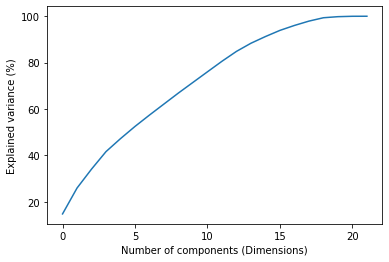

In [89]:
# Do feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [90]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA using 15 as the number of components
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2         3         4         5         6  \
0  3.934168 -0.538394 -0.610097  1.231397 -0.157211 -0.879106  3.726183   
1  2.599740  1.795213  0.643414  4.884679  1.424206 -0.140162 -2.169708   
2  3.429109  1.201471 -0.008620  2.039943 -0.225622 -0.406481 -1.925442   
3  2.587514 -1.284407  0.096818  2.880865 -0.609448 -0.701074 -2.147402   
4  4.615663  1.107481  0.175981  0.821016 -1.165525 -0.639887 -2.221110   

          7         8         9        10        11        12        13  \
0  0.210044 -0.023938 -0.822951 -0.902078 -0.082903  0.071801 -1.797242   
1  0.868210 -0.615264 -0.231858  0.281309 -0.090239  0.968072 -2.158033   
2  1.562684 -0.839111 -0.822476 -0.131608 -0.204364  0.451835 -1.454080   
3  1.163661 -0.856170 -1.020834 -0.252806 -0.259607  0.413838  0.333069   
4  1.226351 -0.892186 -0.945798 -0.274658 -0.122909 -0.214610 -0.292808   

         14  
0  1.021171  
1 -1.899510  
2  1.462225  
3  0.398591  
4 -0.223251  

Size: 
(1309,

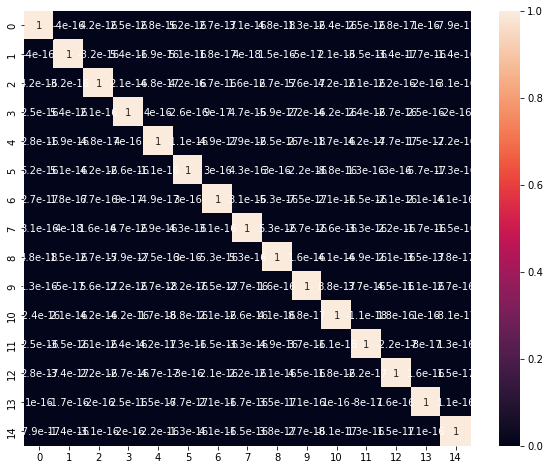

In [91]:
# Create a heatmap of transformed data set
import seaborn as sns
fig = plt.figure(figsize=(10, 8))
sns.heatmap(X_pca.corr(), 
            annot=True)

### Split data into training and testing datasets using train_test_split

In [92]:
# Split data into training and testing
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(1047, 22)

### Create logistic regression model

In [93]:
# Create a logistic regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=800, random_state=1)

# Fit and train the model using the training data
classifier.fit(X_train_pca, y_train)

LogisticRegression(max_iter=800, random_state=1)

In [94]:
# Make predictions
predictions = classifier.predict(X_test_pca)

### Evaluate the models performance

In [95]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Classification report
target_names = ["Did not survive", "Survived"]

# Print the evaluation
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"")
print(f"")
display(cm_df)
print(f"")
print(f"")
print(classification_report(y_test, predictions, target_names=target_names))

The balanced accuracy score of the model is 0.7808866995073892




,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,179,24
Actual - Survived,40,85




                 precision    recall  f1-score   support

Did not survive       0.82      0.88      0.85       203
       Survived       0.78      0.68      0.73       125

       accuracy                           0.80       328
      macro avg       0.80      0.78      0.79       328
   weighted avg       0.80      0.80      0.80       328

